# Gromov-Wassertein optimal transport for multi-omics single-cell alignment

### TL;DR

This notebook presents an application of OTT's Gromov_Wassertein optimal transport to match single-cell points clouds from two different measurement spaces (e.g. mapping gene expressions measurements to chromatine accessibility measurements). 
It is adapted from *Demetci et al, Gromov-Wasserstein optimal transport to align single-cell multi-omics data, ICML 2020 Workshop on Computational Biology, 2020* (ICML article [here](https://icml-compbio.github.io/icml-website-2020/2020/papers/WCBICML2020_paper_51.pdf), a more complete article is however available on [BioRXiv](https://www.biorxiv.org/content/10.1101/2020.04.28.066787v2)).

### Why Gromov Wassertein optimal transport ?


**Context**\
Gene expression profiles with ScRNA-seq give access the transcriptome at the cell level. In addition, a [variety of single-cell measurements](https://en.wikipedia.org/wiki/Single-cell_analysis) can help explore other characteristics of the cell that are helpful to fully understand mechanisms explored in biology. These other measurements can for instance [describe epigenetic changes](https://en.wikipedia.org/wiki/Single_cell_epigenomics) (DNA methylation, chromatin accessibility, histone modifications, chromosome conformation), or the genome itself as well as the proteins present in the cell ([single cell sequencing](https://en.wikipedia.org/wiki/Single_cell_sequencing#Single-cell_genome_(DNA)_sequencing)).

**Challenges**\
As presented in the `application_biology.ipynb` notebook, identification of cells across multiple measures through time must be understood at the lineage level, since measurements are destructive. However, for a given time of experiment, performing measures of different natures give rise to a second challenge, which is that of establishing a correspondance across two (or several) measurement spaces that are unrelated, in the sense that no biological-based theory allow to construct a unambiguous mapping between them.

**Wishlist**\
Alignment between the two measurement spaces can therefore be done in an unsupervised fashion. During experiments, the population of cells measured is the same, and that a  within a given subset, cells are likely to share close genomes, transcriptomes, proteomes and epigenetic changes. Therefore, the objective of building a mapping from one set of points in a measurement space to a second one that would preserve the geometry (or at least the relative closeness) of the points cloud seems to make sense.

**Gromov Wasserstein OT as the ideal candidate**\
The Gromov Wasserstein-based optimal transport, implemented in OTT, is a very relevant candidate to perform such an unsupervised cell alignment. This application has been proposed  by *Demetci et al, Gromov-Wasserstein optimal transport to align single-cell multi-omics data, ICML 2020 Workshop on Computational Biology, 2020*  (ICML article [here](https://icml-compbio.github.io/icml-website-2020/2020/papers/WCBICML2020_paper_51.pdf), more complete article available on [BioRXiv](https://www.biorxiv.org/content/10.1101/2020.04.28.066787v2)). Their algorithm is coined SCOT, for Single-Cell alignment using Optimal Transport, and their source code is available [here](https://github.com/rsinghlab/SCOT)




### This notebook


The original SCOT code uses [POT](https://github.com/PythonOT/POT) (Python Optimal Transport). In this notebook, we propose a slight modification of the SCOT code to use the [`gromov_wasserstein`](https://ott-jax.readthedocs.io/en/latest/notebooks/gromov_wasserstein.html) function from `ott.core`, which we have found to be faster than the POT implementation `ot.gromov.entropic_gromov_wasserstein` in our experiments.
 
We then use this OTT version of the SCOT algorithm to perform cell alignment for the [SNARE-seq dataset](https://www.nature.com/articles/s41587-019-0290-0) (thoroughly presented in the BioRXiv version of *Gromov-Wasserstein optimal transport to align single-cell multi-omics data*), which contains measures of two natures :
 - Chromatin accessibility ([scATAC-seq](https://en.wikipedia.org/wiki/ATAC-seq) data)
 - Gene expression ([scRNA-seq](https://en.wikipedia.org/wiki/Single_cell_sequencing#scRNA-Seq) data)

At the end of the notebook, you will find several visualizations of the results.

Note that this notebook is designed to be self-contained : you should be able to run it locally without having to manually download data or packages.

## Dataset loading 

We must clone the SCOT repo within the folder that contains this notebook. For later access to data present in the cloned repo, only relative paths are used.

In [ ]:
!git clone https://github.com/rsinghlab/SCOT

In [13]:
import numpy as np
X = np.load("SCOT/data/scatac_feat.npy") 
y = np.load("SCOT/data/scrna_feat.npy")
print("Dimensions of input datasets:")
print("X =", X.shape, "=> ie",X.shape[0], "samples belonging to a chromatin accessibility feature space of dimension",X.shape[1])
print("y =", y.shape, " => ie",y.shape[0], "samples belonging to a gene expression feature space of dimension",y.shape[1])


Dimensions of input datasets:
X = (1047, 19) => ie 1047 samples belonging to a chromatin accessibility feature space of dimension 19
y = (1047, 10)  => ie 1047 samples belonging to a gene expression feature space of dimension 10


## Imports and installations 

We make sure ott-jax is installed and that we match SCOT's requirements :

In [14]:
%pip install ott-jax
%pip install -r SCOT/src/requirements.txt
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

from matplotlib import animation
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import ott
from ott.core import gromov_wasserstein as gw

from ot.gromov import init_matrix, gwloss
from SCOT.src.scot import SCOT

## Using `gromov_wasserstein` from `ott.core` to perform optimal transport

The following `OTTSCOT` class inherits from the `SCOT` class but overrides the `find_correspondences` method in order to use OTT instead of POT.

The matrix T is the optimal transport matrix, mapping X to y.

In [17]:
class OTTSCOT(SCOT):
  
  def __init__(self, domain1, domain2):
    super(OTTSCOT, self).__init__(domain1, domain2)
    
  def find_correspondences(self, e, verbose=True):
    geom_xx = ott.geometry.Geometry(self.Cx)
    geom_yy = ott.geometry.Geometry(self.Cy)
    
    T = gw.gromov_wasserstein(geom_xx=geom_xx, geom_yy=geom_yy,
                            epsilon=e, max_iterations=200,
                            a=self.p, b=self.q,
                            jit=True).matrix

    constC, hC1, hC2 = init_matrix(self.Cx, self.Cy, self.p, self.q, loss_fun='square_loss')
    self.gwdist = gwloss(constC, hC1, hC2, np.array(T))
    self.coupling = T

    if (np.isnan(self.coupling).any() or np.any(~self.coupling.any(axis=1)) or np.any(~self.coupling.any(axis=0)) or sum(sum(self.coupling)) < .95):
      self.flag=False
    else:
      self.flag=True

In the Gromov-Wassertein optimal transport, we have two hyperparameters to tune : epsilon, which controls entropy in the regularized optimization problem, and k, that is the number of nearest neighbours that we will consider for building the initial graphs that will allow us to define a notion of closeness between points from the same domain.
The `SCOT` class implements an unsupervized hyperparmeter search method which for our `OTTSCOT` outputs optimal values of 40 for the  number of neighbors k and 0.001 for epsilon. \
We will retain these values for the rest of the exploration of the SNARE-seq dataset. 

## Alignment and evaluation

We align X on y, so we only have to retrieve the first element of the `OTTSCOT` output :

In [76]:
ottscot = OTTSCOT(X, y)
X_shifted, y_shifted = ottscot.align(k=40, e=1e-3,  normalize=True, norm="l2")

For this dataset, we actually a ground truth alignment, since we have the identity of each cell for gene expression and chromatin accesibility measurements. The metric is the fraction of samples closer than the true match (FOSCTTM). Refer to the article for more details.

In [120]:
from SCOT.src import evals
fractions = evals.calc_domainAveraged_FOSCTTM(X_shifted, y_shifted)
print("The average FOSCTTM for the alignment of X (chromatine accessibility domain) on y (gene expression domain) is: ", np.mean(fractions).round(3))

The average FOSCTTM for the alignment of X (chromatine accessibility domain) on y (gene expression domain) is:  0.222


## Visualisations

We can begin by having a look a two Principal Components Analyses of both domains :

Text(0.5, 1.0, 'PCA of gene expression before alignment, \n colored according to cell type')

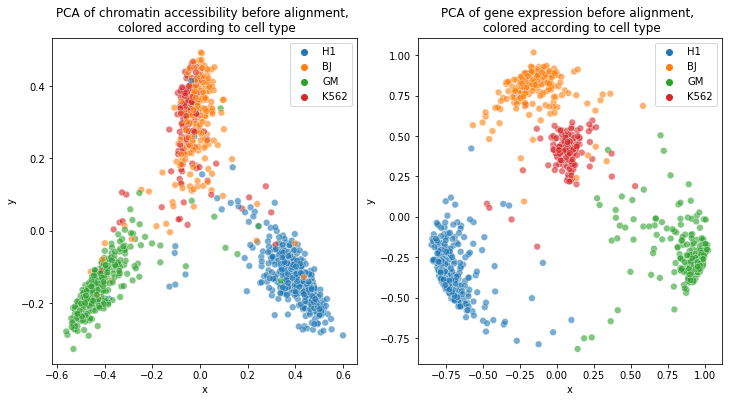

In [111]:
cellTypes_atac=np.loadtxt("SCOT/data/SNAREseq_atac_types.txt")
cellTypes_rna=np.loadtxt("SCOT/data/SNAREseq_rna_types.txt")

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(ottscot.X)

cell_types = list(set(cellTypes_atac))
cell_types_names = ["H1", "GM", "BJ", "K562"]
colors = ["blue", "purple", "red", "green"]

df1 = pd.DataFrame({'x': np.flip(X_pca[:,0]),
                   'y': np.flip(X_pca[:,1]),
                   'cellTypes': np.flip([cell_types_names[int(type)-1] for type in cellTypes_atac])})


sn.scatterplot(data=df1, x="x", y="y",
                hue="cellTypes", s=45,
                alpha=0.6, edgecolors='none',
                ax=ax1)
ax1.legend()
ax1.set_title("PCA of chromatin accessibility before alignment, \n colored according to cell type")

pca = PCA(n_components=2)
y_pca = pca.fit_transform(ottscot.y)
df1 = pd.DataFrame({'x': np.flip(y_pca[:,0]),
                   'y': np.flip(y_pca[:,1]),
                   'cellTypes': np.flip([cell_types_names[int(type)-1] for type in cellTypes_rna])})

sn.scatterplot(data=df1, x="x", y="y",
                hue="cellTypes", s=45,
                alpha=0.6, edgecolors='none',
                ax=ax2)

ax2.legend()
ax2.set_title("PCA of gene expression before alignment, \n colored according to cell type")

Then, let's visualize the superposition of chromatin accessibility points mapped to gene expression domain to the original points cloud of gene expression data :

Text(0.5, 1.0, 'PCA of chromatin accessibility points mapped to gene expression domain, \n along with original gene expression points, \n colored according to cell type')

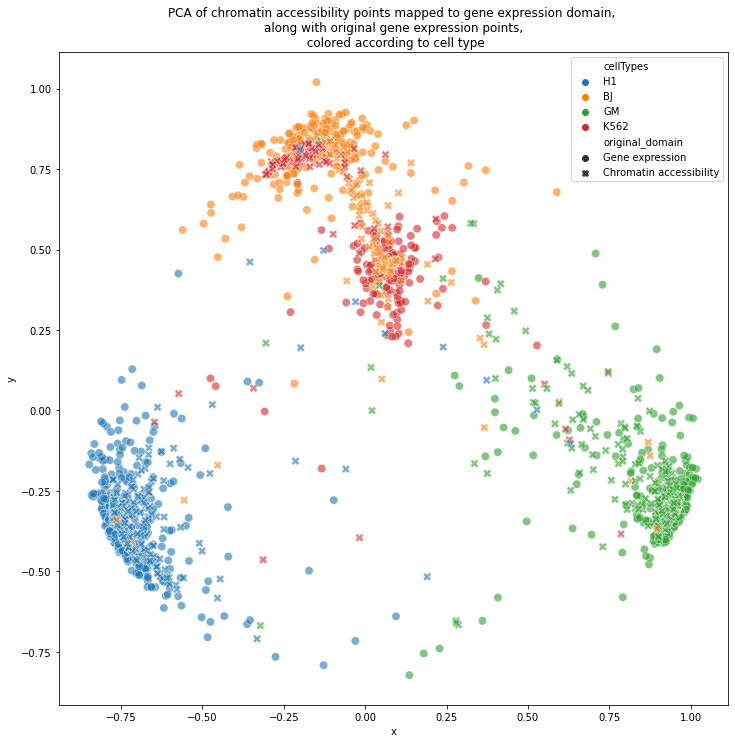

In [112]:
fig, ax = plt.subplots(figsize=(12,12))
n_samples = len(X)
pca = PCA(n_components=2)

Xy_pca = pca.fit_transform(np.concatenate((X_shifted, y_shifted), axis=0))

cell_types = list(set(cellTypes_atac))
cell_types_names = ["H1", "GM", "BJ", "K562"]
cellTypes_atac_rna = np.concatenate(([cell_types_names[int(type)-1] for type in cellTypes_atac],
                                     [cell_types_names[int(type)-1] for type in cellTypes_rna]), axis=0)
original_domain_type = np.concatenate((np.full(n_samples, "Chromatin accessibility"), np.full(n_samples, "Gene expression"),), axis=0)

df = pd.DataFrame({'x': np.flip(Xy_pca[:,0]),
                   'y': np.flip(Xy_pca[:,1]),
                   'cellTypes': np.flip(cellTypes_atac_rna),
                   'original_domain':np.flip(original_domain_type)})


sn.scatterplot(data=df, x="x", y="y",
                hue="cellTypes", s=70,
                style="original_domain",
                alpha=0.6, edgecolors='none')

ax.legend()
ax.set_title("PCA of chromatin accessibility points mapped to gene expression domain, \n along with original gene expression points, \n colored according to cell type")

This superpostion is even clearer if we animate it with the following chunk of code :

In [115]:

fig = plt.figure(figsize=(9,9)) 
line, = plt.plot([], []) 

def animate(i):
    plt.clf()
    if i==0:
        sn.scatterplot(data=df1, x="x", y="y",
                hue="cellTypes", s=70,
                alpha=0.6, edgecolors='none')
        plt.title("PCA of gene expression before alignment, \n colored according to cell type")
    else:
        sn.scatterplot(data=df, x="x", y="y",
                hue="cellTypes", s=70,
                style="original_domain",
                alpha=0.6, edgecolors='none')
        plt.title("PCA of chromatin accessibility points mapped to gene expression domain, \n along with original gene expression points, \n colored according to cell type")
    return line,

def init():
    line.set_data([], [])
    return line,


anim = animation.FuncAnimation(fig, animate, init_func = init,
                               frames= [0,1],  # Ic, c'est la valeur de k
                               interval=1500, blit=True)
                               

html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()

There are endless visualizations that we could perform with these animated plots. An example provided below explores the visual evolution of the optimal transport when we move the hyperparameter k (the number of neighbours):

In [99]:
k_values = [10,20,40,80,100] 
pointclouds_pairs = []
for k in k_values:
    X_new, y_new = ottscot.align(k=k, e=1e-3,  normalize=True, norm="l2")
    pointclouds_pairs.append((X_new, y_new))

In [116]:

fig = plt.figure(figsize=(9,9)) 
line, = plt.plot([], []) 

def animate(i):
    plt.clf()
    k = k_values[i]
    (X_new, y_new) = pointclouds_pairs[i]
    pca = PCA(n_components=2)
    Xy_pca = pca.fit_transform(np.concatenate((X_new, y_new), axis=0))

    df_new = pd.DataFrame({'x': np.flip(Xy_pca[:,0]),
                    'y': np.flip(Xy_pca[:,1]),
                    'cellTypes': np.flip(cellTypes_atac_rna),
                    'original_domain':np.flip(original_domain_type)})

    sn.scatterplot(data=df_new, x="x", y="y",
                    hue="cellTypes", s=70,
                    style="original_domain",
                    alpha=0.6, edgecolors='none')

    plt.title("PCA of chromatin accessibility points mapped to gene expression domain, \n along with original gene expression points for k=" +str(k))

    return line,

def init():
    line.set_data([], [])
    return line,

anim = animation.FuncAnimation(fig, animate, init_func = init,
                               frames=list(range(5)),
                               interval=1500, blit=True)
                               

html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()